In [1]:
from matplotlib  import pyplot as plt
%config InlineBackend.figure_format = 'retina'

from functools        import reduce
from h5py             import File
from glob             import glob
from os               import makedirs
from os.path          import exists, isdir
from pandas           import read_csv
from scipy.io.wavfile import read as readWave

import numpy       as np
import librosa     as lbr

from magenta.music.audio_io      import int16_samples_to_float32, crop_samples
from magenta.music.midi_io       import midi_file_to_note_sequence
from magenta.music.sequences_lib import sequence_to_pianoroll, apply_sustain_control_changes
from magenta.models.onsets_frames_transcription.split_audio_and_label_data import find_split_points


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



# Dataset: MAESTRO (MIDI and Audio Edited<br>for Synchronous TRacks and Organization)
Downloaded from Google Magenta: https://magenta.tensorflow.org/datasets/maestro#download
## Warning
For some samples last midi note onsets are slightly beyond the duration of the corresponding WAV-audio.


# Not used datasets

## Not used: MAPS (from Fichiers - Aix-Marseille Université)
https://amubox.univ-amu.fr/index.php/s/iNG0xc5Td1Nv4rR

### Issue 1 (small dataset and not as natural)
From https://arxiv.org/pdf/1810.12247.pdf, Page 4, Section 3 "Dataset":

`MAPS ... “performances” are not as natural as the MAESTRO performances captured from live performances.  In addition, synthesized audio makes up a large fraction of the MAPS dataset.`

### Issue 2 (skipped notes)
From https://arxiv.org/pdf/1710.11153.pdf, Page 6, Section 6 "Need for more data, more rigorous evaluation":

`In addition to the small number of the MAPS Disklavier recordings, we have also noticed several cases where the Disklavier appears to skip some notes played at low velocity. For example, at the beginning of the Beethoven Sonata No. 9, 2nd movement, several Ab notes played with MIDI velocities in the mid-20s are clearly missing from the audio...`

### Issue 3 (two chords instead of one)

There is an issue with datasets __*"ENSTDkAm"*__ & __*"ENSTDkCl"*__, subtypes __*"RAND"*__ & __*"UCHO"*__.  They are assumed to have only one chord per one WAV-file.  But sometimes the chord is split into two onset times in corresponding MIDI and TXT-files, and those two onset times fall into two consecutive time-frames of cqt-transform (or mel-transform).

## Not used: MusicNET (from University of Washington Computer Science & Engineering)
https://homes.cs.washington.edu/~thickstn/musicnet.html

From https://arxiv.org/pdf/1810.12247.pdf, Page 4, Section 3 "Dataset":

`As discussed in Hawthorne et al. (2018), the alignment between audio and score is not fully accurate.  One advantage of MusicNet is that it contains instruments other than piano` ... `and a wider variety of recording environments.`

# Train/Test Split

From https://arxiv.org/pdf/1810.12247.pdf, Page 4, Section 3.2 "Dataset Splitting":

1. `No composition should appear in more than one split.`


2. `... proportions should be true globally and also within each composer.  Maintaining these proportions is not always possible because some composers have too few compositions in the dataset.`


3. `The validation and test splits should contain a variety of compositions.  Extremely popular compositions performed by many performers should be placed in the training split.`


4. `... we recommend using the splits which we have provided.`

In [2]:
dataFolder = 'Maestro'

NotExists = lambda song, name: not exists('{} {}.npy'.format(song, name))

df = read_csv(dataFolder + '\maestro-v1.0.0.csv', verbose=True)
df

Tokenization took: 1.00 ms
Type conversion took: 2.99 ms
Parser memory cleanup took: 0.00 ms


,canonical_composer,canonical_title,split,year,midi_filename,audio_filename,duration
0,Alban Berg,Sonata Op. 1,train,2017,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...,464.649433
1,Alban Berg,Sonata Op. 1,train,2008,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...,759.518471
2,Alexander Scriabin,"24 Preludes Op. 11, No. 13-24",train,2004,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...,872.640588
3,Alexander Scriabin,"3 Etudes, Op. 65",test,2006,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...,397.857508
4,Alexander Scriabin,"5 Preludes, Op.15",train,2009,2009/MIDI-Unprocessed_07_R1_2009_04-05_ORIG_MI...,2009/MIDI-Unprocessed_07_R1_2009_04-05_ORIG_MI...,400.557826
5,Alexander Scriabin,"Entragete, Op.63",test,2009,2009/MIDI-Unprocessed_11_R1_2009_06-09_ORIG_MI...,2009/MIDI-Unprocessed_11_R1_2009_06-09_ORIG_MI...,163.745830
6,Alexander Scriabin,"Etude Op. 2 No.1; Etudes Op. 8, Nos. 5, 11 an...",train,2013,2013/ORIG-MIDI_03_7_8_13_Group__MID--AUDIO_19_...,2013/ORIG-MIDI_03_7_8_13_Group__MID--AUDIO_19_...,563.904351
7,Alexander Scriabin,"Etude Op. 42, Nos. 4 & 5",validation,2009,2009/MIDI-Unprocessed_02_R1_2009_03-06_ORIG_MI...,2009/MIDI-Unprocessed_02_R1_2009_03-06_ORIG_MI...,136.315302
8,Alexander Scriabin,"Etude Op. 8, No. 13",train,2009,2009/MIDI-Unprocessed_02_R1_2009_03-06_ORIG_MI...,2009/MIDI-Unprocessed_02_R1_2009_03-06_ORIG_MI...,167.085837
9,Alexander Scriabin,"Etude in D-flat Major, Op. 8 No. 10",train,2011,2011/MIDI-Unprocessed_15_R1_2011_MID--AUDIO_R1...,2011/MIDI-Unprocessed_15_R1_2011_MID--AUDIO_R1...,102.007110


# Mel-transform parameters
Don't know why not use Constant-Q transform, but from https://arxiv.org/pdf/1710.11153.pdf, Page 2, Section 3 "Model Configuration":

`We use librosa` ... `to compute the same input data representation of mel-scaled spectrograms with log amplitude of the input raw audio with 229 logarithmically-spaced frequency bins, a hop length of 512, an FFT window of 2048, and a sample rate of 16kHz.`

From https://arxiv.org/pdf/1810.12247.pdf, Page 5, Section 4 "Piano Transcription":

`switched to HTK frequency spacing (Young et al., 2006) for the mel-frequency spectrogram input.`

Mel-frequency values are strange:

$f_{min} = 30 Hz$, but the first "A" note of 1st octave is *27.5 Hz*

$f_{max} = 11 025 Hz$ (librosa default), and it is much higher than the last "C" note of 8th octave (*4 186 Hz*).  So, mel-spectrogram will contain lots of high harmonics, and maybe, it will help the CNN-model correctly identify notes in the last octaves.

Maybe (don't know) Mel-scaled spectrogram is used instead of Constant-Q transform, because CQT-transform produces equal number of bins for each note, while mel-frequencies are located such that there are more nearby frequencies for higher notes.  So, mel-spectrogram provides more input data for higher octaves, and the CNN-model can transcribe higher notes with better accuracy.  It can help solve the issue with lots of annoying false-positive notes in high octaves.

## Additional non-linear logarithmic scaling
librosa.power_to_db, ref=1 (default) --> mels decibels are approximately in range *[-40 ... +40]*

# MIDI Pre-Processing
From https://arxiv.org/pdf/1710.11153.pdf

Page 2, Section 2 "Dataset and Metrics":

`... we first translate “sustain pedal” control changes into longer note durations.  If a note is active when sustain goes on, that note will be extended until either sustain goes off or the same note is played again.`

Page 3, Section 3, "Model Configuration":

`... all onsets will end up spanning exactly two frames.  Labeling only the frame that contains the exact beginning of the onset does not work as well because of possible mis-alignments of the audio and labels.  We experimented with requiring a minimum amount of time a note had to be present in a frame before it was labeled, but found that the optimum value was to include any presence.`

# Number of time-frames: 625 + 1 (20 seconds at sample rate of 16 kHz)
From https://arxiv.org/pdf/1710.11153.pdf, Page 2, Section 3 "Model Configuration":

`... we split the training audio into smaller files.  However, when we do this splitting we do not want to cut the audio during notes because the onset detector would miss an onset while the frame detector would still need to predict the note’s presence.  We found that 20 second splits allowed us to achieve a reasonable batch size during training of at least 8, while also forcing splits in only a small number of places where notes are active.`

In [3]:
rate, minSecs, maxSecs, melsMinMin, melsMinMax, melsMeanMin, melsMeanMax, melsMaxMin, melsMaxMax \
    = 16_000, 1, 5, -40, -40, -0, -0, 40, 40
nFrames = lbr.time_to_frames(maxSecs, rate) + 1

for yearFolder in glob(dataFolder + '\*\\'):
    if yearFolder.split('\\')[1] in ['train', 'test', 'validation']: continue
    print(yearFolder, end='\n\n')
    for i, song in enumerate(glob(yearFolder + '\*.wav')):
        year, songFile = song.split('\\')[1:]
        csvRow = df.loc[df['audio_filename'] == '/'.join([year, songFile])]
        assert csvRow['year'].to_list()[0] == int(year), 'CSV year is incorrect'
        split = csvRow['split'].to_list()
        assert len(split) == 1, 'CSV train/test split is incorrect'
        split = split[0]
        if not isdir('{}/{}/{}'.format(dataFolder, split, year)): makedirs('{}/{}/{}'.format(dataFolder, split, year))
        print('{} of {}\t{}\t{}'.format(i + 1, len(glob(yearFolder + '\*.wav')), split, song))

        if any(list(map(lambda name: NotExists('{}/{}/{}/{}'.format(dataFolder, split, year, songFile[:-4]), name),
                        ['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes']))):
            ######################################################################################################
            # From https://github.com/tensorflow/magenta/blob/master/magenta/music/audio_io.py
            
            nativeRate, y = readWave(song)
            if y.dtype == np.int16: y = int16_samples_to_float32(y)
            elif y.dtype != np.float32: raise AudioIOError('WAV file not 16-bit or 32-bit float PCM, unsupported')
            
            if y.ndim == 2 and y.shape[1] == 2: y = lbr.to_mono(y.T)
            if nativeRate != rate: y = lbr.resample(y, nativeRate, rate)
            
            ######################################################################################################
            # From https://github.com/tensorflow/magenta/blob/master/magenta/models/onsets_frames_transcription/split_audio_and_label_data.py
            # def process_record(..., min_length=5, max_length=20, sample_rate=16000,
            #     allow_empty_notesequence=False, load_audio_with_librosa=False)
            
            samples = lbr.util.normalize(y)
            sequence = apply_sustain_control_changes(midi_file_to_note_sequence(song[:-3] + 'midi'))
            roll = sequence_to_pianoroll(sequence, 1 / lbr.frames_to_time(1, rate), 21, 108,
                                         onset_length_ms=32, offset_length_ms=32, onset_mode='length_ms')
            splits = [0, sequence.total_time] if split == 'test' else \
                find_split_points(sequence, samples, rate, minSecs, maxSecs)

            mels, onsets, offsets, actives, volumes = [], [], [], [], []
            for i, (start, end) in enumerate(zip(splits[:-1], splits[1:])):
                print('\tFragment {} of {}'.format(i + 1, len(splits) - 1), end='\t')
                if end - start < minSecs:
                    if i not in [0, len(splits) - 2]: print('WARNING: ', end='')
                    print('Skipping short sequence < {} seconds'.format(minSecs))
                    continue
                
                # Resampling in crop_wav_data is really slow, and we have already done it once, avoid doing it twice:
                newMels = lbr.power_to_db(lbr.feature.melspectrogram(samples if start == 0
                        and end == sequence.total_time else crop_samples(samples, rate, start, end - start),
                    rate, n_mels=229, fmin=30, htk=True).astype(np.float32).T).astype(np.float16)
                newOnsets, newOffsets, newActives, newVolumes = map(lambda arr:arr[
                        lbr.time_to_frames(start + lbr.frames_to_time(1, rate) / 2, rate) :
                        lbr.time_to_frames(  end + lbr.frames_to_time(1, rate) / 2, rate) + 1],
                    [roll.onsets, roll.offsets, roll.active, roll.onset_velocities])
                if split != 'test':
                    if len(newOnsets) == len(newMels) + 1: newOnsets, newOffsets, newActives, newVolumes \
                        = newOnsets[:-1], newOffsets[:-1], newActives[:-1], newVolumes[:-1]
                    elif len(newMels) == len(newOnsets) + 1: newMels = newMels[:-1]
                elif len(newOnsets) < len(newMels): newMels = newMels[:len(newOnsets)]
                assert split == 'test' or len(newOnsets) == len(newMels), \
                    'Spectrogram duration is different from piano rolls durations'

                if not newOnsets.sum():
                    if i not in [0, len(splits) - 2]: print('WARNING: ', end='')
                    print('Skipping empty sequence')
                    continue
                try: assert melsMinMin < newMels.min() < melsMinMax and melsMeanMin < newMels.mean() < melsMeanMax \
                    and melsMaxMin < newMels.max() < melsMaxMax, 'Wrong mels decibels range'
                except:
                    if i == len(splits) - 2 and newMels.min() == newMels.mean() == newMels.max() == -100:
                        print('WARNING: Skipping strange sequence with all mels = -100 Db')
                        continue
                    else:
                        print(newMels.min(), newMels.mean(), newMels.max())
                        raise

                ########################################################################################################
                # Unfortunately, magenta.music.sequences_lib.extract_subsequence does not take the correct time interval
                # So, we have to manually remove notes which started before the interval:
                for note in newActives[0].nonzero()[0]:
                    for i, act in enumerate(newActives):
                        if newOnsets[i][note] or not act[note]: break
                        newActives[i][note] = 0
                ########################################################################################################

                if split != 'test': newMels, newOnsets, newOffsets, newActives, newVolumes = map(
                    lambda arr: np.pad(arr, [(0, nFrames - len(arr)), (0, 0)], 'minimum' if arr is newMels \
                    else 'constant'), [newMels, newOnsets, newOffsets, newActives, newVolumes])
                assert newMels.shape[:-1] == newOnsets.shape[:-1] == newOffsets.shape[:-1]        \
                        == newActives.shape[:-1] == newVolumes.shape[:-1]                          \
                    and newOnsets.shape == newOffsets.shape == newActives.shape == newVolumes.shape \
                    and newOnsets.shape[1] == 88 and newMels.shape[1] == 229, 'Wrong data shape'
                mels, onsets, offsets, actives, volumes = map(lambda arr, newArr: arr + [newArr],
                    [mels, onsets, offsets, actives, volumes], [newMels, newOnsets, newOffsets, newActives, newVolumes])
                print()
            
            for name, arr in zip(['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes'],
                                 [mels, onsets, offsets, actives, volumes]):
                np.save('{}/{}/{}/{} {}'.format(dataFolder, split, year, songFile[:-4], name), arr)
    print()
'All piano pieces have been processed'

Maestro\2004\

1 of 132	validation	Maestro\2004\MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav.wav
2 of 132	train	Maestro\2004\MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav.wav
3 of 132	train	Maestro\2004\MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_08_Track08_wav.wav
4 of 132	validation	Maestro\2004\MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_10_Track10_wav.wav
5 of 132	train	Maestro\2004\MIDI-Unprocessed_SMF_05_R1_2004_01_ORIG_MID--AUDIO_05_R1_2004_02_Track02_wav.wav
6 of 132	train	Maestro\2004\MIDI-Unprocessed_SMF_05_R1_2004_01_ORIG_MID--AUDIO_05_R1_2004_03_Track03_wav.wav
7 of 132	train	Maestro\2004\MIDI-Unprocessed_SMF_05_R1_2004_02-03_ORIG_MID--AUDIO_05_R1_2004_06_Track06_wav.wav
8 of 132	train	Maestro\2004\MIDI-Unprocessed_SMF_07_R1_2004_01_ORIG_MID--AUDIO_07_R1_2004_02_Track02_wav.wav
9 of 132	train	Maestro\2004\MIDI-Unprocessed_SMF_07_R1_2004_01_ORIG_MID--AUDIO_07_R1_200

78 of 132	train	Maestro\2004\MIDI-Unprocessed_XP_10_R1_2004_01-02_ORIG_MID--AUDIO_10_R1_2004_01_Track01_wav.wav
79 of 132	train	Maestro\2004\MIDI-Unprocessed_XP_10_R1_2004_01-02_ORIG_MID--AUDIO_10_R1_2004_02_Track02_wav.wav
80 of 132	train	Maestro\2004\MIDI-Unprocessed_XP_10_R1_2004_03-04_ORIG_MID--AUDIO_10_R1_2004_03_Track03_wav.wav
81 of 132	train	Maestro\2004\MIDI-Unprocessed_XP_10_R1_2004_05_ORIG_MID--AUDIO_10_R1_2004_05_Track05_wav.wav
82 of 132	train	Maestro\2004\MIDI-Unprocessed_XP_11_R1_2004_01-02_ORIG_MID--AUDIO_11_R1_2004_01_Track01_wav.wav
83 of 132	test	Maestro\2004\MIDI-Unprocessed_XP_11_R1_2004_01-02_ORIG_MID--AUDIO_11_R1_2004_02_Track02_wav.wav
84 of 132	train	Maestro\2004\MIDI-Unprocessed_XP_11_R1_2004_03-04_ORIG_MID--AUDIO_11_R1_2004_03_Track03_wav.wav
85 of 132	train	Maestro\2004\MIDI-Unprocessed_XP_11_R1_2004_03-04_ORIG_MID--AUDIO_11_R1_2004_04_Track04_wav.wav
86 of 132	train	Maestro\2004\MIDI-Unprocessed_XP_14_R1_2004_01-03_ORIG_MID--AUDIO_14_R1_2004_01_Track01_wav.

35 of 115	validation	Maestro\2006\MIDI-Unprocessed_07_R2_2006_01_ORIG_MID--AUDIO_07_R2_2006_04_Track04_wav.wav
36 of 115	train	Maestro\2006\MIDI-Unprocessed_08_R1_2006_01-04_ORIG_MID--AUDIO_08_R1_2006_Disk1_01_Track01_wav.wav
37 of 115	validation	Maestro\2006\MIDI-Unprocessed_08_R1_2006_01-04_ORIG_MID--AUDIO_08_R1_2006_Disk1_02_Track02_wav.wav
38 of 115	train	Maestro\2006\MIDI-Unprocessed_08_R1_2006_01-04_ORIG_MID--AUDIO_08_R1_2006_Disk1_03_Track03_wav.wav
39 of 115	train	Maestro\2006\MIDI-Unprocessed_08_R2_2006_01_ORIG_MID--AUDIO_08_R2_2006_01_Track01_wav.wav
40 of 115	train	Maestro\2006\MIDI-Unprocessed_08_R2_2006_01_ORIG_MID--AUDIO_08_R2_2006_02_Track02_wav.wav
41 of 115	train	Maestro\2006\MIDI-Unprocessed_08_R2_2006_01_ORIG_MID--AUDIO_08_R2_2006_03_Track03_wav.wav
42 of 115	test	Maestro\2006\MIDI-Unprocessed_09_R1_2006_01-04_ORIG_MID--AUDIO_09_R1_2006_01_Track01_wav.wav
43 of 115	train	Maestro\2006\MIDI-Unprocessed_09_R1_2006_01-04_ORIG_MID--AUDIO_09_R1_2006_02_Track02_wav.wav
44 o

2 of 147	validation	Maestro\2008\MIDI-Unprocessed_01_R1_2008_01-04_ORIG_MID--AUDIO_01_R1_2008_wav--2.wav
3 of 147	train	Maestro\2008\MIDI-Unprocessed_01_R1_2008_01-04_ORIG_MID--AUDIO_01_R1_2008_wav--3.wav
4 of 147	train	Maestro\2008\MIDI-Unprocessed_02_R1_2008_01-05_ORIG_MID--AUDIO_02_R1_2008_wav--1.wav
5 of 147	train	Maestro\2008\MIDI-Unprocessed_02_R1_2008_01-05_ORIG_MID--AUDIO_02_R1_2008_wav--2.wav
6 of 147	test	Maestro\2008\MIDI-Unprocessed_02_R1_2008_01-05_ORIG_MID--AUDIO_02_R1_2008_wav--3.wav
7 of 147	train	Maestro\2008\MIDI-Unprocessed_02_R1_2008_01-05_ORIG_MID--AUDIO_02_R1_2008_wav--4.wav
8 of 147	train	Maestro\2008\MIDI-Unprocessed_02_R1_2008_01-05_ORIG_MID--AUDIO_02_R1_2008_wav--5.wav
9 of 147	test	Maestro\2008\MIDI-Unprocessed_02_R2_2008_01-05_ORIG_MID--AUDIO_02_R2_2008_wav--1.wav
10 of 147	train	Maestro\2008\MIDI-Unprocessed_02_R2_2008_01-05_ORIG_MID--AUDIO_02_R2_2008_wav--3.wav
11 of 147	train	Maestro\2008\MIDI-Unprocessed_02_R2_2008_01-05_ORIG_MID--AUDIO_02_R2_2008_wav--4

97 of 147	train	Maestro\2008\MIDI-Unprocessed_10_R3_2008_01-05_ORIG_MID--AUDIO_10_R3_2008_wav--3.wav
98 of 147	train	Maestro\2008\MIDI-Unprocessed_10_R3_2008_01-05_ORIG_MID--AUDIO_10_R3_2008_wav--4.wav
99 of 147	train	Maestro\2008\MIDI-Unprocessed_10_R3_2008_01-05_ORIG_MID--AUDIO_10_R3_2008_wav--5.wav
100 of 147	train	Maestro\2008\MIDI-Unprocessed_11_R1_2008_01-04_ORIG_MID--AUDIO_11_R1_2008_wav--1.wav
101 of 147	validation	Maestro\2008\MIDI-Unprocessed_11_R1_2008_01-04_ORIG_MID--AUDIO_11_R1_2008_wav--2.wav
102 of 147	train	Maestro\2008\MIDI-Unprocessed_11_R1_2008_01-04_ORIG_MID--AUDIO_11_R1_2008_wav--3.wav
103 of 147	train	Maestro\2008\MIDI-Unprocessed_11_R1_2008_01-04_ORIG_MID--AUDIO_11_R1_2008_wav--4.wav
104 of 147	train	Maestro\2008\MIDI-Unprocessed_11_R2_2008_01-05_ORIG_MID--AUDIO_11_R2_2008_wav--2.wav
105 of 147	train	Maestro\2008\MIDI-Unprocessed_11_R2_2008_01-05_ORIG_MID--AUDIO_11_R2_2008_wav--3.wav
106 of 147	train	Maestro\2008\MIDI-Unprocessed_11_R2_2008_01-05_ORIG_MID--AUDIO_

42 of 125	train	Maestro\2009\MIDI-Unprocessed_08_R2_2009_01_ORIG_MID--AUDIO_08_R2_2009_08_R2_2009_01_WAV.wav
43 of 125	train	Maestro\2009\MIDI-Unprocessed_08_R2_2009_01_ORIG_MID--AUDIO_08_R2_2009_08_R2_2009_02_WAV.wav
44 of 125	train	Maestro\2009\MIDI-Unprocessed_08_R2_2009_01_ORIG_MID--AUDIO_08_R2_2009_08_R2_2009_03_WAV.wav
45 of 125	train	Maestro\2009\MIDI-Unprocessed_08_R2_2009_01_ORIG_MID--AUDIO_08_R2_2009_08_R2_2009_04_WAV.wav
46 of 125	train	Maestro\2009\MIDI-Unprocessed_09_R1_2009_01-04_ORIG_MID--AUDIO_09_R1_2009_09_R1_2009_01_WAV.wav
47 of 125	train	Maestro\2009\MIDI-Unprocessed_09_R1_2009_01-04_ORIG_MID--AUDIO_09_R1_2009_09_R1_2009_02_WAV.wav
48 of 125	test	Maestro\2009\MIDI-Unprocessed_09_R1_2009_01-04_ORIG_MID--AUDIO_09_R1_2009_09_R1_2009_03_WAV.wav
49 of 125	train	Maestro\2009\MIDI-Unprocessed_09_R1_2009_01-04_ORIG_MID--AUDIO_09_R1_2009_09_R1_2009_04_WAV.wav
50 of 125	validation	Maestro\2009\MIDI-Unprocessed_09_R1_2009_05-06_ORIG_MID--AUDIO_09_R1_2009_09_R1_2009_05_WAV.wav


1 of 163	train	Maestro\2011\MIDI-Unprocessed_01_R1_2011_MID--AUDIO_R1-D1_02_Track02_wav.wav
2 of 163	train	Maestro\2011\MIDI-Unprocessed_01_R1_2011_MID--AUDIO_R1-D1_03_Track03_wav.wav
3 of 163	train	Maestro\2011\MIDI-Unprocessed_01_R1_2011_MID--AUDIO_R1-D1_04_Track04_wav.wav
4 of 163	train	Maestro\2011\MIDI-Unprocessed_01_R1_2011_MID--AUDIO_R1-D1_05_Track05_wav.wav
5 of 163	validation	Maestro\2011\MIDI-Unprocessed_01_R1_2011_MID--AUDIO_R1-D1_06_Track06_wav.wav
6 of 163	train	Maestro\2011\MIDI-Unprocessed_02_R1_2011_MID--AUDIO_R1-D1_08_Track08_wav.wav
7 of 163	train	Maestro\2011\MIDI-Unprocessed_02_R1_2011_MID--AUDIO_R1-D1_09_Track09_wav.wav
8 of 163	train	Maestro\2011\MIDI-Unprocessed_02_R1_2011_MID--AUDIO_R1-D1_10_Track10_wav.wav
9 of 163	train	Maestro\2011\MIDI-Unprocessed_02_R2_2011_MID--AUDIO_R2-D1_02_Track02_wav.wav
10 of 163	train	Maestro\2011\MIDI-Unprocessed_02_R2_2011_MID--AUDIO_R2-D1_03_Track03_wav.wav
11 of 163	train	Maestro\2011\MIDI-Unprocessed_03_R1_2011_MID--AUDIO_R1-D1_

99 of 163	test	Maestro\2011\MIDI-Unprocessed_16_R1_2011_MID--AUDIO_R1-D6_15_Track15_wav.wav
100 of 163	validation	Maestro\2011\MIDI-Unprocessed_16_R2_2011_MID--AUDIO_R2-D4_08_Track08_wav.wav
101 of 163	train	Maestro\2011\MIDI-Unprocessed_16_R2_2011_MID--AUDIO_R2-D4_09_Track09_wav.wav
102 of 163	train	Maestro\2011\MIDI-Unprocessed_16_R3_2011_MID--AUDIO_R3-D5_02_Track02_wav.wav
103 of 163	train	Maestro\2011\MIDI-Unprocessed_17_R1_2011_MID--AUDIO_R1-D7_02_Track02_wav.wav
104 of 163	train	Maestro\2011\MIDI-Unprocessed_17_R1_2011_MID--AUDIO_R1-D7_03_Track03_wav.wav
105 of 163	train	Maestro\2011\MIDI-Unprocessed_17_R1_2011_MID--AUDIO_R1-D7_04_Track04_wav.wav
106 of 163	train	Maestro\2011\MIDI-Unprocessed_17_R1_2011_MID--AUDIO_R1-D7_05_Track05_wav.wav
107 of 163	train	Maestro\2011\MIDI-Unprocessed_17_R2_2011_MID--AUDIO_R2-D5_03_Track03_wav.wav
108 of 163	train	Maestro\2011\MIDI-Unprocessed_17_R2_2011_MID--AUDIO_R2-D5_04_Track04_wav.wav
109 of 163	train	Maestro\2011\MIDI-Unprocessed_17_R2_2011

40 of 127	train	Maestro\2013\ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_14_R1_2013_wav--4.wav
41 of 127	train	Maestro\2013\ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_02_R2_2013_wav--1.wav
42 of 127	train	Maestro\2013\ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_02_R2_2013_wav--2.wav
43 of 127	train	Maestro\2013\ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_02_R2_2013_wav--3.wav
44 of 127	train	Maestro\2013\ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_02_R2_2013_wav--5.wav
45 of 127	train	Maestro\2013\ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_03_R2_2013_wav--1.wav
46 of 127	train	Maestro\2013\ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_03_R2_2013_wav--2.wav
47 of 127	test	Maestro\2013\ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_04_R2_2013_wav--1.wav
48 of 127	validation	Maestro\2013\ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_04_R2_2013_wav--3.wav
49 of 127	train	Maestro\2013\ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_07_R2_2013_wav--1.wav
50 of 127	test	Maestro\2013\ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_07_R2_2013_wav--2.wav
51 of 127	train	Ma

13 of 106	train	Maestro\2014\MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_03_R1_2014_wav--6.wav
14 of 106	train	Maestro\2014\MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_04_R1_2014_wav--1.wav
15 of 106	test	Maestro\2014\MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_04_R1_2014_wav--2.wav
16 of 106	validation	Maestro\2014\MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_04_R1_2014_wav--3.wav
17 of 106	train	Maestro\2014\MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_04_R1_2014_wav--4.wav
18 of 106	train	Maestro\2014\MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_04_R1_2014_wav--5.wav
19 of 106	train	Maestro\2014\MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_05_R1_2014_wav--1.wav
20 of 106	train	Maestro\2014\MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_05_R1_2014_wav--2.wav
21 of 106	train	Maestro\2014\MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_05_R1_2014_wav--4.wav
22 of 106	test	Maestro\2014\MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_05_R1_2014_wav--5.wav
23 of 106	validation	Maestro\2014\MIDI-UNPROCESSED_04-05_R1_2014_MI

4 of 129	train	Maestro\2015\MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_01_R1_2015_wav--5.wav
5 of 129	train	Maestro\2015\MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_02_R1_2015_wav--1.wav
6 of 129	train	Maestro\2015\MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_02_R1_2015_wav--2.wav
7 of 129	test	Maestro\2015\MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_02_R1_2015_wav--3.wav
8 of 129	train	Maestro\2015\MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_02_R1_2015_wav--4.wav
9 of 129	train	Maestro\2015\MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_02_R1_2015_wav--5.wav
10 of 129	train	Maestro\2015\MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_02_R1_2015_wav--6.wav
11 of 129	train	Maestro\2015\MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_03_R1_2015_wav--1.wav
12 of 129	train	Maestro\2015\MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_03_R1_2015_wav--2.wav
13 of 129	validation	Maestro\2015\MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_03_R1_2015_wav--3.wav
14 of 129	train	Maestr

100 of 129	train	Maestro\2015\MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_06_R2_2015_wav--4.wav
101 of 129	validation	Maestro\2015\MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_07_R2_2015_wav--1.wav
102 of 129	train	Maestro\2015\MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_07_R2_2015_wav--2.wav
103 of 129	train	Maestro\2015\MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_07_R2_2015_wav--3.wav
104 of 129	train	Maestro\2015\MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_08_R2_2015_wav--1.wav
105 of 129	train	Maestro\2015\MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_08_R2_2015_wav--2.wav
106 of 129	train	Maestro\2015\MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_08_R2_2015_wav--3.wav
107 of 129	train	Maestro\2015\MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_11_R2_2015_wav--1.wav
108 of 129	train	Maestro\2015\MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_11_R2_2015_wav--2.wav
109 of 129	train	Maestr

65 of 140	test	Maestro\2017\MIDI-Unprocessed_057_PIANO057_MID--AUDIO-split_07-07-17_Piano-e_1-07_wav--3.wav
66 of 140	train	Maestro\2017\MIDI-Unprocessed_057_PIANO057_MID--AUDIO-split_07-07-17_Piano-e_1-07_wav--4.wav
67 of 140	train	Maestro\2017\MIDI-Unprocessed_057_PIANO057_MID--AUDIO-split_07-07-17_Piano-e_1-07_wav--5.wav
68 of 140	train	Maestro\2017\MIDI-Unprocessed_058_PIANO058_MID--AUDIO-split_07-07-17_Piano-e_2-02_wav--1.wav
69 of 140	train	Maestro\2017\MIDI-Unprocessed_058_PIANO058_MID--AUDIO-split_07-07-17_Piano-e_2-02_wav--2.wav
70 of 140	validation	Maestro\2017\MIDI-Unprocessed_058_PIANO058_MID--AUDIO-split_07-07-17_Piano-e_2-02_wav--3.wav
71 of 140	train	Maestro\2017\MIDI-Unprocessed_058_PIANO058_MID--AUDIO-split_07-07-17_Piano-e_2-02_wav--4.wav
72 of 140	train	Maestro\2017\MIDI-Unprocessed_058_PIANO058_MID--AUDIO-split_07-07-17_Piano-e_2-02_wav--5.wav
73 of 140	train	Maestro\2017\MIDI-Unprocessed_059_PIANO059_MID--AUDIO-split_07-07-17_Piano-e_2-03_wav--1.wav
74 of 140	train

'All piano pieces have been processed'

In [5]:
for splitFolder in ['train', 'test', 'validation']:
    print(splitFolder)
    for yearFolder in glob('{}\{}\*\\'.format(dataFolder, splitFolder)):
        yearFolder = int(yearFolder.split('\\')[2])
        print('\t', yearFolder, end='\n\n')
        mels, onsets, offsets, actives, volumes = [], [], [], [], []
        for i, [newMels, newOnsets, newOffsets, newActives, newVolumes] in enumerate(zip(*(
                glob('{}\{}\{}\*{}.npy'.format(dataFolder, splitFolder, yearFolder, arr))
                for arr in ['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes']))):
            song = newMels.split(' ')[0]
            assert song == newOnsets.split(' ')[0] == newOffsets.split(' ')[0] == newActives.split(' ')[0] \
                == newVolumes.split(' ')[0], 'Inconsistent number of numpy arrays'
            print('{} of {}'.format(i + 1, len(glob('{}\{}\{}\*Actives.npy'.format(
                dataFolder, splitFolder, yearFolder)))), end='\t')

            newMels, newOnsets, newOffsets, newActives, newVolumes = map(
                lambda arr: np.load(arr, allow_pickle=True), [newMels, newOnsets, newOffsets, newActives, newVolumes])
            mels, onsets, offsets, actives, volumes = map(lambda arr, newArr: (arr + newArr.tolist())
                if splitFolder == 'test' else np.vstack([arr, newArr]) if len(arr) else newArr,
                [mels, onsets, offsets, actives, volumes], [newMels, newOnsets, newOffsets, newActives, newVolumes])
            print(song)
        
        if splitFolder != 'test':
            mels, volumes = map(lambda arr: arr.astype(np.float16), [mels, volumes])
            onsets, offsets, actives = map(lambda arr: arr.astype(np.int8), [onsets, offsets, actives])
        for name, arr in zip(['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes'], [mels, onsets, offsets, actives, volumes]):
            np.save('{}/{}/{} {}'.format(dataFolder, splitFolder, yearFolder, name), arr)
        print('\n', len(actives), 'samples')
        
        melsFlat, volsFlat = map(np.concatenate, [mels, volumes])
        print('Mels decibels           in range [{:.0f} ... {:.0f} ... {:.0f}]'.format(
            melsFlat.min(), melsFlat.mean(), melsFlat.max()))
        assert melsMinMin < melsFlat.min() < melsMinMax and melsMeanMin < melsFlat.mean() < melsMeanMax \
            and melsMaxMin < melsFlat.max() < melsMaxMax, 'Wrong mels decibels range'

        print('Midi normalized volumes in range [{} ... {:.4f} ... {:.2f}]\n'.format(
            volsFlat.min(), volsFlat.mean(), volsFlat.max()))
        for arr in map(np.concatenate, [onsets, offsets, actives]): assert ((arr == 0) | (arr == 1)).all(), \
                'Onsets, offsets and actives must be only zeros and ones'
        assert volsFlat.min() == 0 and 0 < volsFlat.max() <= 1, 'Wrong normalized MIDI volumes range'

    print(splitFolder, 'saved\n')
'All years combined'

train
	 2004

1 of 117	Maestro\train\2004\MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav
2 of 117	Maestro\train\2004\MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_08_Track08_wav
3 of 117	Maestro\train\2004\MIDI-Unprocessed_SMF_05_R1_2004_01_ORIG_MID--AUDIO_05_R1_2004_02_Track02_wav
4 of 117	Maestro\train\2004\MIDI-Unprocessed_SMF_05_R1_2004_01_ORIG_MID--AUDIO_05_R1_2004_03_Track03_wav
5 of 117	Maestro\train\2004\MIDI-Unprocessed_SMF_05_R1_2004_02-03_ORIG_MID--AUDIO_05_R1_2004_06_Track06_wav
6 of 117	Maestro\train\2004\MIDI-Unprocessed_SMF_07_R1_2004_01_ORIG_MID--AUDIO_07_R1_2004_02_Track02_wav
7 of 117	Maestro\train\2004\MIDI-Unprocessed_SMF_07_R1_2004_01_ORIG_MID--AUDIO_07_R1_2004_04_Track04_wav
8 of 117	Maestro\train\2004\MIDI-Unprocessed_SMF_07_R1_2004_01_ORIG_MID--AUDIO_07_R1_2004_06_Track06_wav
9 of 117	Maestro\train\2004\MIDI-Unprocessed_SMF_07_R1_2004_01_ORIG_MID--AUDIO_07_R1_2004_12_Track12_wav
10 of 117	Maestro\train\2004\MID

77 of 117	Maestro\train\2004\MIDI-Unprocessed_XP_14_R1_2004_04_ORIG_MID--AUDIO_14_R1_2004_06_Track06_wav
78 of 117	Maestro\train\2004\MIDI-Unprocessed_XP_14_R2_2004_01_ORIG_MID--AUDIO_14_R2_2004_01_Track01_wav
79 of 117	Maestro\train\2004\MIDI-Unprocessed_XP_14_R2_2004_01_ORIG_MID--AUDIO_14_R2_2004_02_Track02_wav
80 of 117	Maestro\train\2004\MIDI-Unprocessed_XP_14_R2_2004_01_ORIG_MID--AUDIO_14_R2_2004_03_Track03_wav
81 of 117	Maestro\train\2004\MIDI-Unprocessed_XP_14_R2_2004_01_ORIG_MID--AUDIO_14_R2_2004_04_Track04_wav
82 of 117	Maestro\train\2004\MIDI-Unprocessed_XP_15_R1_2004_01-02_ORIG_MID--AUDIO_15_R1_2004_02_Track02_wav
83 of 117	Maestro\train\2004\MIDI-Unprocessed_XP_15_R1_2004_04_ORIG_MID--AUDIO_15_R1_2004_04_Track04_wav
84 of 117	Maestro\train\2004\MIDI-Unprocessed_XP_15_R2_2004_01_ORIG_MID--AUDIO_15_R2_2004_01_Track01_wav
85 of 117	Maestro\train\2004\MIDI-Unprocessed_XP_15_R2_2004_01_ORIG_MID--AUDIO_15_R2_2004_02_Track02_wav
86 of 117	Maestro\train\2004\MIDI-Unprocessed_XP_15_

37 of 87	Maestro\train\2006\MIDI-Unprocessed_09_R2_2006_01_ORIG_MID--AUDIO_09_R2_2006_01_Track01_wav
38 of 87	Maestro\train\2006\MIDI-Unprocessed_09_R2_2006_01_ORIG_MID--AUDIO_09_R2_2006_02_Track02_wav
39 of 87	Maestro\train\2006\MIDI-Unprocessed_10_R1_2006_01-04_ORIG_MID--AUDIO_10_R1_2006_02_Track02_wav
40 of 87	Maestro\train\2006\MIDI-Unprocessed_10_R1_2006_01-04_ORIG_MID--AUDIO_10_R1_2006_05_Track05_wav
41 of 87	Maestro\train\2006\MIDI-Unprocessed_11_R1_2006_01-06_ORIG_MID--AUDIO_11_R1_2006_01_Track01_wav
42 of 87	Maestro\train\2006\MIDI-Unprocessed_11_R1_2006_01-06_ORIG_MID--AUDIO_11_R1_2006_04_Track04_wav
43 of 87	Maestro\train\2006\MIDI-Unprocessed_12_R1_2006_01-08_ORIG_MID--AUDIO_12_R1_2006_01_Track01_wav
44 of 87	Maestro\train\2006\MIDI-Unprocessed_12_R1_2006_01-08_ORIG_MID--AUDIO_12_R1_2006_04_Track04_wav
45 of 87	Maestro\train\2006\MIDI-Unprocessed_12_R1_2006_01-08_ORIG_MID--AUDIO_12_R1_2006_05_Track05_wav
46 of 87	Maestro\train\2006\MIDI-Unprocessed_12_R1_2006_01-08_ORIG_MID

30 of 112	Maestro\train\2008\MIDI-Unprocessed_06_R1_2008_01-04_ORIG_MID--AUDIO_06_R1_2008_wav--1
31 of 112	Maestro\train\2008\MIDI-Unprocessed_06_R1_2008_01-04_ORIG_MID--AUDIO_06_R1_2008_wav--2
32 of 112	Maestro\train\2008\MIDI-Unprocessed_06_R1_2008_01-04_ORIG_MID--AUDIO_06_R1_2008_wav--4
33 of 112	Maestro\train\2008\MIDI-Unprocessed_06_R2_2008_01-05_ORIG_MID--AUDIO_06_R2_2008_wav--1
34 of 112	Maestro\train\2008\MIDI-Unprocessed_06_R2_2008_01-05_ORIG_MID--AUDIO_06_R2_2008_wav--3
35 of 112	Maestro\train\2008\MIDI-Unprocessed_06_R2_2008_01-05_ORIG_MID--AUDIO_06_R2_2008_wav--4
36 of 112	Maestro\train\2008\MIDI-Unprocessed_06_R2_2008_01-05_ORIG_MID--AUDIO_06_R2_2008_wav--5
37 of 112	Maestro\train\2008\MIDI-Unprocessed_07_R1_2008_01-04_ORIG_MID--AUDIO_07_R1_2008_wav--1
38 of 112	Maestro\train\2008\MIDI-Unprocessed_07_R1_2008_01-04_ORIG_MID--AUDIO_07_R1_2008_wav--3
39 of 112	Maestro\train\2008\MIDI-Unprocessed_07_R1_2008_01-04_ORIG_MID--AUDIO_07_R1_2008_wav--4
40 of 112	Maestro\train\2008\M

	 2009

1 of 95	Maestro\train\2009\MIDI-Unprocessed_01_R1_2009_01-04_ORIG_MID--AUDIO_01_R1_2009_01_R1_2009_02_WAV
2 of 95	Maestro\train\2009\MIDI-Unprocessed_02_R1_2009_01-02_ORIG_MID--AUDIO_02_R1_2009_02_R1_2009_01_WAV
3 of 95	Maestro\train\2009\MIDI-Unprocessed_02_R1_2009_01-02_ORIG_MID--AUDIO_02_R1_2009_02_R1_2009_02_WAV
4 of 95	Maestro\train\2009\MIDI-Unprocessed_02_R1_2009_03-06_ORIG_MID--AUDIO_02_R1_2009_02_R1_2009_05_WAV
5 of 95	Maestro\train\2009\MIDI-Unprocessed_03_R1_2009_01-02_ORIG_MID--AUDIO_03_R1_2009_03_R1_2009_02_WAV
6 of 95	Maestro\train\2009\MIDI-Unprocessed_03_R1_2009_03-08_ORIG_MID--AUDIO_03_R1_2009_03_R1_2009_05_WAV
7 of 95	Maestro\train\2009\MIDI-Unprocessed_03_R1_2009_03-08_ORIG_MID--AUDIO_03_R1_2009_03_R1_2009_06_WAV
8 of 95	Maestro\train\2009\MIDI-Unprocessed_03_R1_2009_03-08_ORIG_MID--AUDIO_03_R1_2009_03_R1_2009_07_WAV
9 of 95	Maestro\train\2009\MIDI-Unprocessed_03_R1_2009_03-08_ORIG_MID--AUDIO_03_R1_2009_03_R1_2009_08_WAV
10 of 95	Maestro\train\2009\MIDI-Unpro

79 of 95	Maestro\train\2009\MIDI-Unprocessed_18_R1_2009_01-03_ORIG_MID--AUDIO_18_R1_2009_18_R1_2009_02_WAV
80 of 95	Maestro\train\2009\MIDI-Unprocessed_18_R1_2009_04_ORIG_MID--AUDIO_18_R1_2009_18_R1_2009_04_WAV
81 of 95	Maestro\train\2009\MIDI-Unprocessed_19_R1_2009_01-02_ORIG_MID--AUDIO_19_R1_2009_19_R1_2009_02_WAV
82 of 95	Maestro\train\2009\MIDI-Unprocessed_19_R1_2009_03-04_ORIG_MID--AUDIO_19_R1_2009_19_R1_2009_04_WAV
83 of 95	Maestro\train\2009\MIDI-Unprocessed_19_R2_2009_01_ORIG_MID--AUDIO_19_R2_2009_19_R2_2009_01_WAV
84 of 95	Maestro\train\2009\MIDI-Unprocessed_19_R2_2009_01_ORIG_MID--AUDIO_19_R2_2009_19_R2_2009_02_WAV
85 of 95	Maestro\train\2009\MIDI-Unprocessed_19_R2_2009_01_ORIG_MID--AUDIO_19_R2_2009_19_R2_2009_03_WAV
86 of 95	Maestro\train\2009\MIDI-Unprocessed_19_R2_2009_01_ORIG_MID--AUDIO_19_R2_2009_19_R2_2009_04_WAV
87 of 95	Maestro\train\2009\MIDI-Unprocessed_20_R1_2009_01-05_ORIG_MID--AUDIO_20_R1_2009_20_R1_2009_01_WAV
88 of 95	Maestro\train\2009\MIDI-Unprocessed_20_R1_2

72 of 139	Maestro\train\2011\MIDI-Unprocessed_12_R3_2011_MID--AUDIO_R3-D4_04_Track04_wav
73 of 139	Maestro\train\2011\MIDI-Unprocessed_12_R3_2011_MID--AUDIO_R3-D4_07_Track07_wav
74 of 139	Maestro\train\2011\MIDI-Unprocessed_12_R3_2011_MID--AUDIO_R3-D4_08_Track08_wav
75 of 139	Maestro\train\2011\MIDI-Unprocessed_12_R3_2011_MID--AUDIO_R3-D4_09_Track09_wav
76 of 139	Maestro\train\2011\MIDI-Unprocessed_13_R1_2011_MID--AUDIO_R1-D5_02_Track02_wav
77 of 139	Maestro\train\2011\MIDI-Unprocessed_13_R1_2011_MID--AUDIO_R1-D5_03_Track03_wav
78 of 139	Maestro\train\2011\MIDI-Unprocessed_13_R1_2011_MID--AUDIO_R1-D5_04_Track04_wav
79 of 139	Maestro\train\2011\MIDI-Unprocessed_14_R1_2011_MID--AUDIO_R1-D6_02_Track02_wav
80 of 139	Maestro\train\2011\MIDI-Unprocessed_14_R1_2011_MID--AUDIO_R1-D6_03_Track03_wav
81 of 139	Maestro\train\2011\MIDI-Unprocessed_15_R1_2011_MID--AUDIO_R1-D6_07_Track07_wav
82 of 139	Maestro\train\2011\MIDI-Unprocessed_15_R1_2011_MID--AUDIO_R1-D6_08_Track08_wav
83 of 139	Maestro\tra

25 of 108	Maestro\train\2013\ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_12_R1_2013_wav--2
26 of 108	Maestro\train\2013\ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_12_R1_2013_wav--3
27 of 108	Maestro\train\2013\ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_12_R1_2013_wav--4
28 of 108	Maestro\train\2013\ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_12_R1_2013_wav--5
29 of 108	Maestro\train\2013\ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_13_R1_2013_wav--2
30 of 108	Maestro\train\2013\ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_13_R1_2013_wav--3
31 of 108	Maestro\train\2013\ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_13_R1_2013_wav--4
32 of 108	Maestro\train\2013\ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_14_R1_2013_wav--1
33 of 108	Maestro\train\2013\ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_14_R1_2013_wav--3
34 of 108	Maestro\train\2013\ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_14_R1_2013_wav--4
35 of 108	Maestro\train\2013\ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_02_R2_2013_wav--1
36 of 108	Maestro\train\2013\ORIG-MIDI_01_7_8_13_Group__MID--AUDI

12 of 76	Maestro\train\2014\MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_05_R1_2014_wav--1
13 of 76	Maestro\train\2014\MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_05_R1_2014_wav--2
14 of 76	Maestro\train\2014\MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_05_R1_2014_wav--4
15 of 76	Maestro\train\2014\MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_05_R1_2014_wav--7
16 of 76	Maestro\train\2014\MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_05_R1_2014_wav--8
17 of 76	Maestro\train\2014\MIDI-UNPROCESSED_04-07-08-10-12-15-17_R2_2014_MID--AUDIO_04_R2_2014_wav
18 of 76	Maestro\train\2014\MIDI-UNPROCESSED_04-07-08-10-12-15-17_R2_2014_MID--AUDIO_07_R2_2014_wav
19 of 76	Maestro\train\2014\MIDI-UNPROCESSED_04-07-08-10-12-15-17_R2_2014_MID--AUDIO_08_R2_2014_wav
20 of 76	Maestro\train\2014\MIDI-UNPROCESSED_04-07-08-10-12-15-17_R2_2014_MID--AUDIO_10_R2_2014_wav
21 of 76	Maestro\train\2014\MIDI-UNPROCESSED_04-07-08-10-12-15-17_R2_2014_MID--AUDIO_12_R2_2014_wav
22 of 76	Maestro\train\2014\MIDI-UNPROCESSED_04-07-08-10-12-

25 of 107	Maestro\train\2015\MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_07_R1_2015_wav--2
26 of 107	Maestro\train\2015\MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_07_R1_2015_wav--3
27 of 107	Maestro\train\2015\MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_07_R1_2015_wav--4
28 of 107	Maestro\train\2015\MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_08_R1_2015_wav--1
29 of 107	Maestro\train\2015\MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_08_R1_2015_wav--2
30 of 107	Maestro\train\2015\MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_08_R1_2015_wav--3
31 of 107	Maestro\train\2015\MIDI-Unprocessed_R1_D1-1-8_mid--AUDIO-from_mp3_08_R1_2015_wav--4
32 of 107	Maestro\train\2015\MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_09_R1_2015_wav--1
33 of 107	Maestro\train\2015\MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_09_R1_2015_wav--3
34 of 107	Maestro\train\2015\MIDI-Unprocessed_R1_D1-9-12_mid--AUDIO-from_mp3_09_R1_2015_wav--4
35 of 107	Maestro\train\2015\MIDI-Unprocessed_R1_D1-9-12_

	 2017

1 of 113	Maestro\train\2017\MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--1
2 of 113	Maestro\train\2017\MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--2
3 of 113	Maestro\train\2017\MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--3
4 of 113	Maestro\train\2017\MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--4
5 of 113	Maestro\train\2017\MIDI-Unprocessed_042_PIANO042_MID--AUDIO-split_07-06-17_Piano-e_1-02_wav--1
6 of 113	Maestro\train\2017\MIDI-Unprocessed_042_PIANO042_MID--AUDIO-split_07-06-17_Piano-e_1-02_wav--2
7 of 113	Maestro\train\2017\MIDI-Unprocessed_042_PIANO042_MID--AUDIO-split_07-06-17_Piano-e_1-02_wav--3
8 of 113	Maestro\train\2017\MIDI-Unprocessed_043_PIANO043_MID--AUDIO-split_07-06-17_Piano-e_1-03_wav--1
9 of 113	Maestro\train\2017\MIDI-Unprocessed_043_PIANO043_MID--AUDIO-split_07-06-17_Piano-e_1-03_wav--2
10 of 113	Maestro\train\2017\MIDI-Unprocessed_043_PIANO0


 22 samples
Mels decibels           in range [-48 ... -27 ... 37]
Midi normalized volumes in range [0.0 ... 0.0035 ... 0.97]

	 2009

1 of 17	Maestro\test\2009\MIDI-Unprocessed_01_R1_2009_01-04_ORIG_MID--AUDIO_01_R1_2009_01_R1_2009_01_WAV
2 of 17	Maestro\test\2009\MIDI-Unprocessed_02_R1_2009_03-06_ORIG_MID--AUDIO_02_R1_2009_02_R1_2009_03_WAV
3 of 17	Maestro\test\2009\MIDI-Unprocessed_03_R1_2009_03-08_ORIG_MID--AUDIO_03_R1_2009_03_R1_2009_04_WAV
4 of 17	Maestro\test\2009\MIDI-Unprocessed_04_R1_2009_04-06_ORIG_MID--AUDIO_04_R1_2009_04_R1_2009_04_WAV
5 of 17	Maestro\test\2009\MIDI-Unprocessed_05_R1_2009_01-02_ORIG_MID--AUDIO_05_R1_2009_05_R1_2009_01_WAV
6 of 17	Maestro\test\2009\MIDI-Unprocessed_06_R1_2009_01-02_ORIG_MID--AUDIO_06_R1_2009_06_R1_2009_02_WAV
7 of 17	Maestro\test\2009\MIDI-Unprocessed_07_R1_2009_01-03_ORIG_MID--AUDIO_07_R1_2009_07_R1_2009_02_WAV
8 of 17	Maestro\test\2009\MIDI-Unprocessed_08_R1_2009_01-04_ORIG_MID--AUDIO_08_R1_2009_08_R1_2009_02_WAV
9 of 17	Maestro\test\2009

12 of 14	Maestro\test\2017\MIDI-Unprocessed_079_PIANO079_MID--AUDIO-split_07-09-17_Piano-e_1-04_wav--2
13 of 14	Maestro\test\2017\MIDI-Unprocessed_079_PIANO079_MID--AUDIO-split_07-09-17_Piano-e_1-04_wav--4
14 of 14	Maestro\test\2017\MIDI-Unprocessed_080_PIANO080_MID--AUDIO-split_07-09-17_Piano-e_1-06_wav--3

 14 samples
Mels decibels           in range [-48 ... -27 ... 36]
Midi normalized volumes in range [0.0 ... 0.0036 ... 0.99]

test saved

validation
	 2004

1 of 6	Maestro\validation\2004\MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav
2 of 6	Maestro\validation\2004\MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_10_Track10_wav
3 of 6	Maestro\validation\2004\MIDI-Unprocessed_SMF_22_R1_2004_01-04_ORIG_MID--AUDIO_22_R1_2004_03_Track03_wav
4 of 6	Maestro\validation\2004\MIDI-Unprocessed_SMF_22_R1_2004_01-04_ORIG_MID--AUDIO_22_R1_2004_05_Track05_wav
5 of 6	Maestro\validation\2004\MIDI-Unprocessed_XP_08_R1_2004_01-02_ORIG_MID--AUDIO_08_R1

3 of 14	Maestro\validation\2014\MIDI-UNPROCESSED_04-05_R1_2014_MID--AUDIO_05_R1_2014_wav--6
4 of 14	Maestro\validation\2014\MIDI-UNPROCESSED_04-08-12_R3_2014_MID--AUDIO_12_R3_2014_wav--1
5 of 14	Maestro\validation\2014\MIDI-UNPROCESSED_09-10_R1_2014_MID--AUDIO_09_R1_2014_wav--4
6 of 14	Maestro\validation\2014\MIDI-UNPROCESSED_09-10_R1_2014_MID--AUDIO_10_R1_2014_wav--1
7 of 14	Maestro\validation\2014\MIDI-UNPROCESSED_11-13_R1_2014_MID--AUDIO_13_R1_2014_wav--4
8 of 14	Maestro\validation\2014\MIDI-UNPROCESSED_14-15_R1_2014_MID--AUDIO_15_R1_2014_wav--2
9 of 14	Maestro\validation\2014\MIDI-UNPROCESSED_14-15_R1_2014_MID--AUDIO_15_R1_2014_wav--3
10 of 14	Maestro\validation\2014\MIDI-UNPROCESSED_14-15_R1_2014_MID--AUDIO_15_R1_2014_wav--4
11 of 14	Maestro\validation\2014\MIDI-UNPROCESSED_16-18_R1_2014_MID--AUDIO_16_R1_2014_wav--2
12 of 14	Maestro\validation\2014\MIDI-UNPROCESSED_16-18_R1_2014_MID--AUDIO_18_R1_2014_wav--1
13 of 14	Maestro\validation\2014\MIDI-UNPROCESSED_19-20_R1_2014_MID--AUDIO

'All years combined'

In [4]:
with File(dataFolder + '/Mels train.hdf5', 'w') as f: #, rdcc_nbytes=1024**3*4) as f: # 4 GB cache size
    for splitFolder in ['train', 'validation']:
        print(splitFolder)
        mels, onsets, offsets, actives, volumes = [], [], [], [], []
        for i, [newMels, newOnsets, newOffsets, newActives, newVolumes] in enumerate(zip(*(glob('{}\{}\*{}.npy'.format(
                dataFolder, splitFolder, arr)) for arr in ['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes']))):
            song = newOnsets.split(' ')[0]
            assert song == newOffsets.split(' ')[0] == newActives.split(' ')[0] == newVolumes.split(' ')[0], \
                'Inconsistent number of numpy arrays'
            print('{} of {}'.format(i + 1, len(glob('{}\{}\*Actives.npy'.format(
                dataFolder, splitFolder)))), end='\t')

            newMels, newOnsets, newOffsets, newActives, newVolumes = map(
                lambda arr: np.load(arr, allow_pickle=True), [newMels, newOnsets, newOffsets, newActives, newVolumes])
            
            if splitFolder == 'train':
                # Memory Error, so at first collect data in resisable HDF5-file, then it can be re-saved to NumPy-file
                if not mels: mels = f.create_dataset('Mels', data=newMels,
                    maxshape=(None, newMels.shape[1], newMels.shape[2])) # chunks=True
                else:
                    mels.resize((len(mels) + len(newMels), mels.shape[1], mels.shape[2]))
                    mels[-len(newMels):] = newMels
            else: mels = (mels + newMels.tolist()) if splitFolder == 'test' \
                else np.vstack([mels, newMels]) if len(mels) else newMels

            onsets, offsets, actives, volumes = map(lambda arr, newArr: (arr + newArr.tolist())
                if splitFolder == 'test' else np.vstack([arr, newArr]) if len(arr) else newArr,
                [onsets, offsets, actives, volumes], [newOnsets, newOffsets, newActives, newVolumes])

            print(song)

        for name, arr in zip(['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes'], [mels, onsets, offsets, actives, volumes]):
            np.save('{}/{} {}'.format(dataFolder, name, splitFolder), arr)
        print('\n', len(actives), 'samples')
        
        melsFlat, volsFlat = map(np.concatenate, [mels, volumes])
        melsMin, melsMean, melsMax = np.min(melsFlat), np.mean(melsFlat), np.max(melsFlat)
        print('Mels decibels           in range [{:.0f} ... {:.0f} ... {:.0f}]'.format(melsMin, melsMean, melsMax))
        assert melsMinMin < melsMin < melsMinMax and melsMeanMin < melsMean < melsMeanMax \
            and melsMaxMin < melsMax < melsMaxMax, 'Wrong mels decibels range'

        print('Midi normalized volumes in range [{} ... {:.4f} ... {:.2f}]\n'.format(
            volsFlat.min(), volsFlat.mean(), volsFlat.max()))
        for arr in map(np.concatenate, [onsets, offsets, actives]): assert ((arr == 0) | (arr == 1)).all(), \
                'Onsets, offsets and actives must be only zeros and ones'
        assert volsFlat.min() == 0 and 0 < volsFlat.max() <= 1, 'Wrong normalized MIDI volumes range'

'All splits combined'

train
1 of 9	Maestro\train\2004
2 of 9	Maestro\train\2006
3 of 9	Maestro\train\2008
4 of 9	Maestro\train\2009
5 of 9	Maestro\train\2011
6 of 9	Maestro\train\2013
7 of 9	Maestro\train\2014
8 of 9	Maestro\train\2015
9 of 9	Maestro\train\2017

 109300 samples
Mels decibels           in range [-92 ... -30 ... 39]
Midi normalized volumes in range [0.0 ... 0.0034 ... 0.99]

validation
1 of 9	Maestro\validation\2004
2 of 9	Maestro\validation\2006
3 of 9	Maestro\validation\2008
4 of 9	Maestro\validation\2009
5 of 9	Maestro\validation\2011
6 of 9	Maestro\validation\2013
7 of 9	Maestro\validation\2014
8 of 9	Maestro\validation\2015
9 of 9	Maestro\validation\2017

 11953 samples
Mels decibels           in range [-92 ... -30 ... 40]
Midi normalized volumes in range [0.0 ... 0.0034 ... 0.99]



'All splits combined'

# Logariphmic distribution of notes

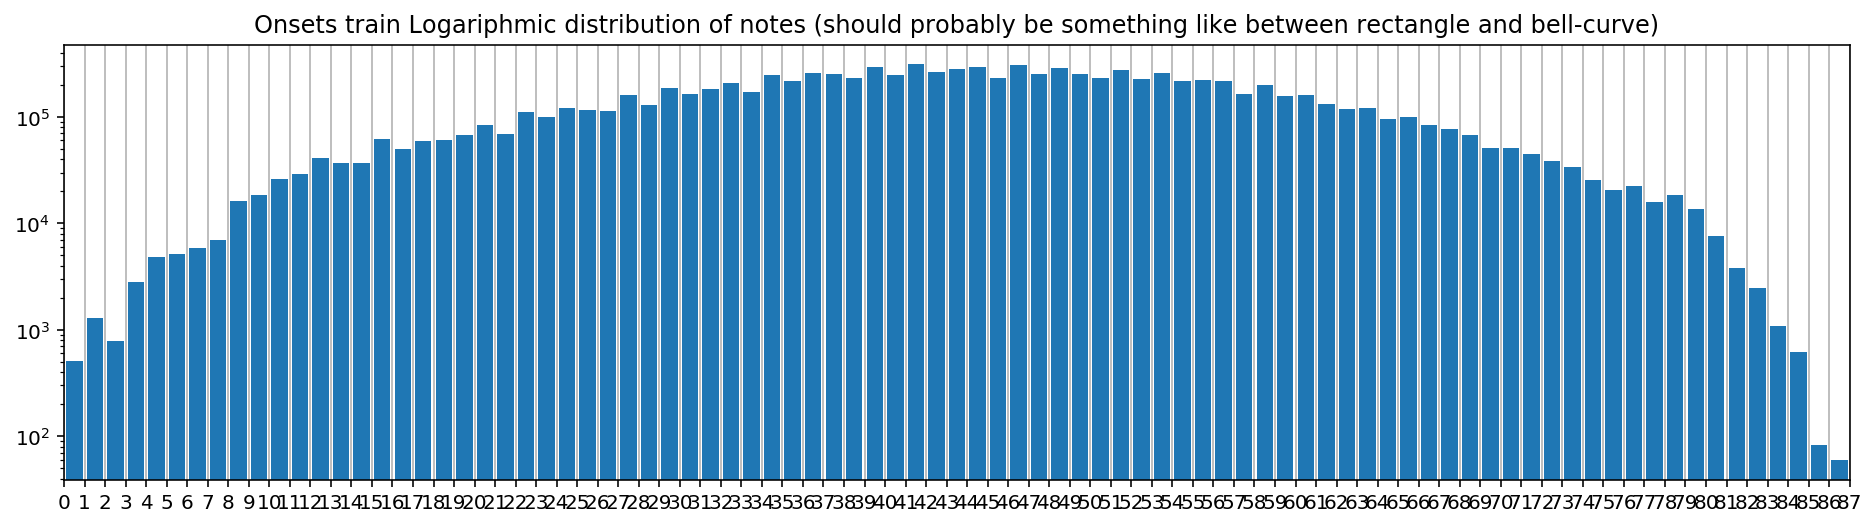

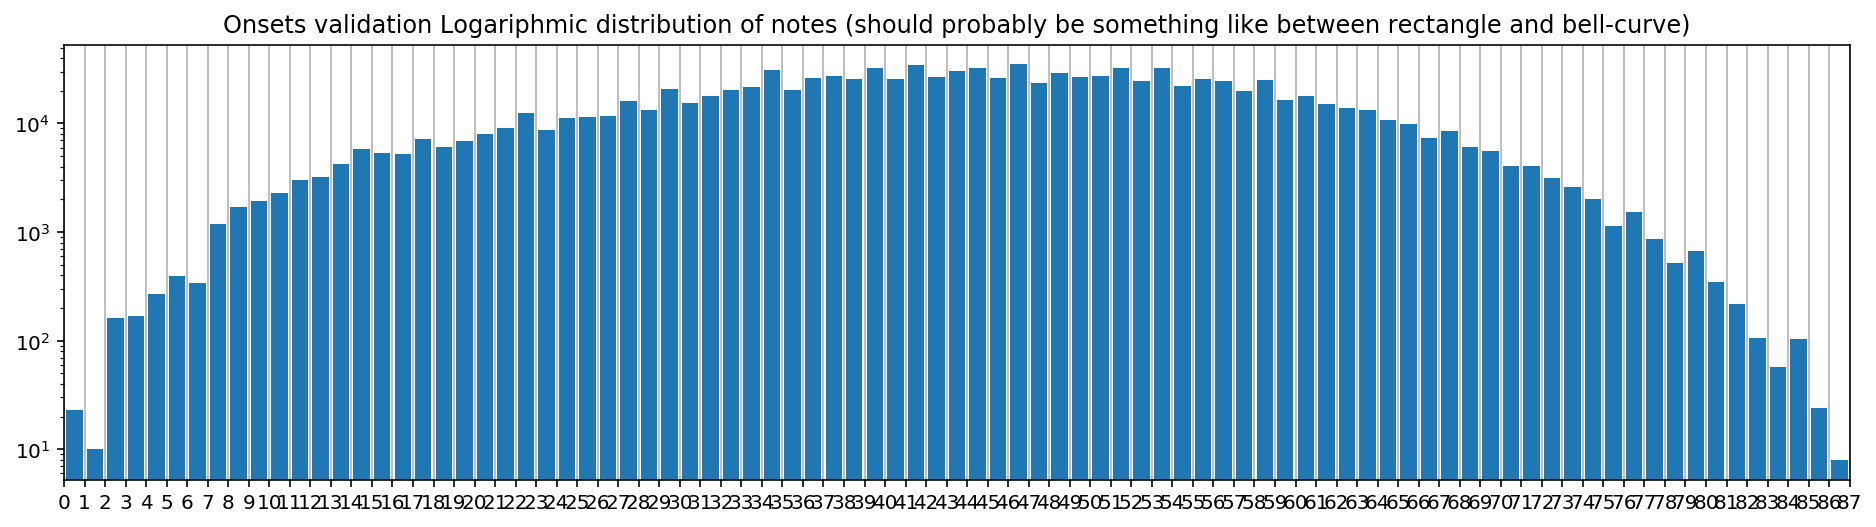

In [5]:
def PlotNotes(name):
#    for split in ['train', 'test', 'validation']:
    for split in ['train', 'validation']:
        noteCounts = np.load('{}/{} {}.npy'.format(dataFolder, name, split)).nonzero()[2]
        minNote, maxNote = noteCounts.min(), noteCounts.max()

        plt.figure(figsize=(16, 8))
        plt.hist(noteCounts, maxNote - minNote, rwidth=.8, log=True)
        plt.title('{} {} Logariphmic distribution of notes '
                  '(should probably be something like between rectangle and bell-curve)'.format(name, split))
        plt.xlim(minNote, maxNote)
        plt.xticks(range(minNote, maxNote + 1))
        plt.grid(axis='x')

PlotNotes('Onsets')

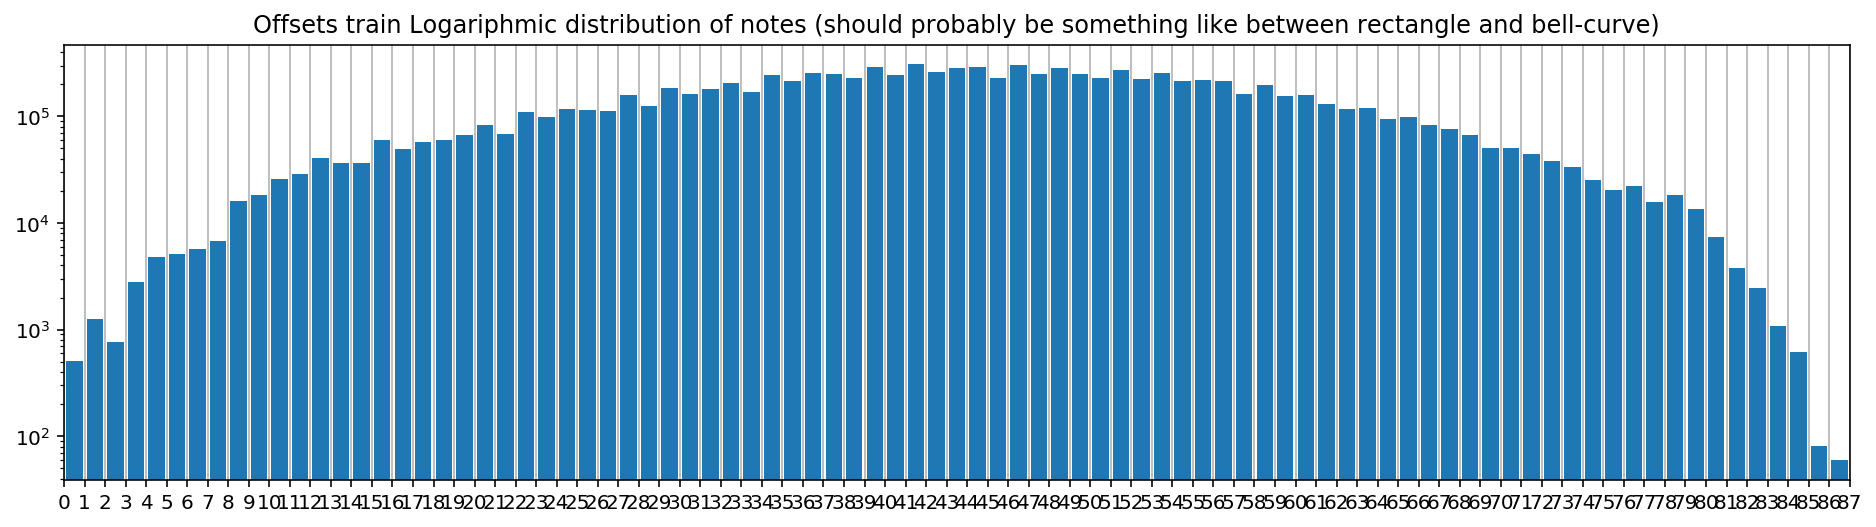

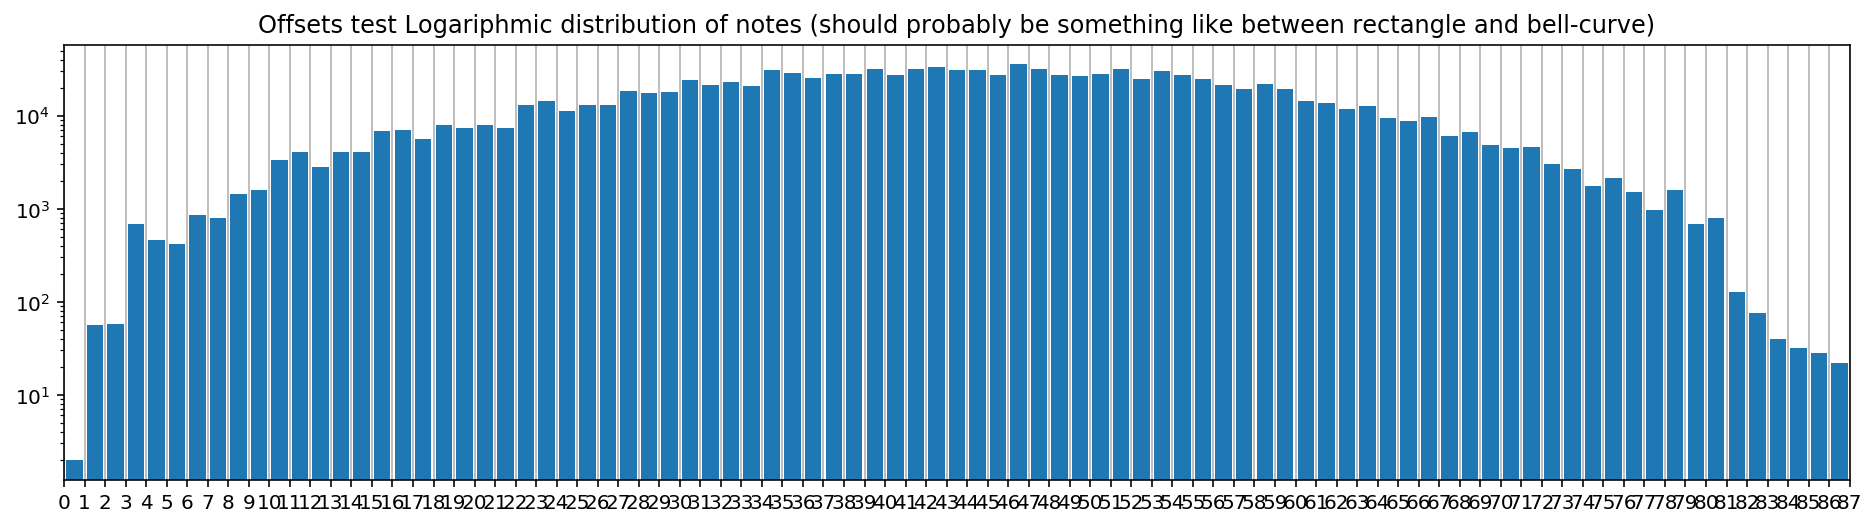

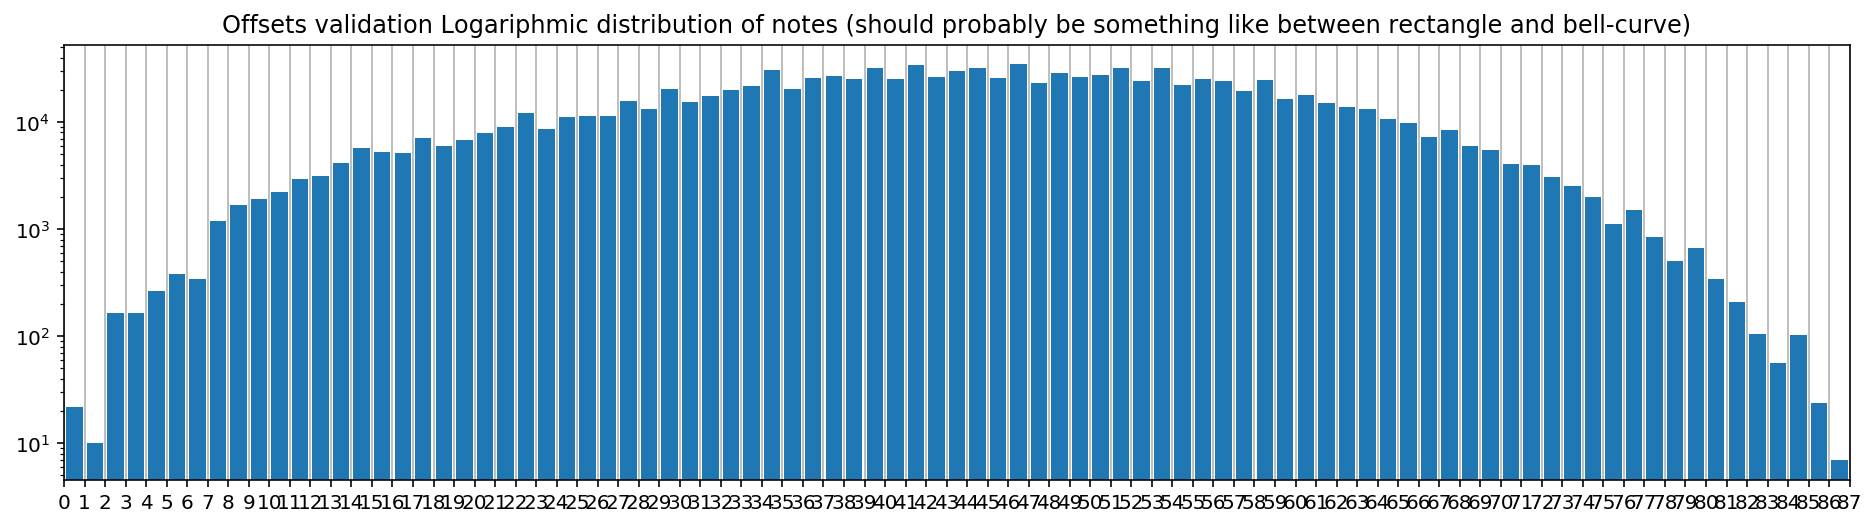

In [7]:
PlotNotes('Offsets') # Should be the same as Onsets

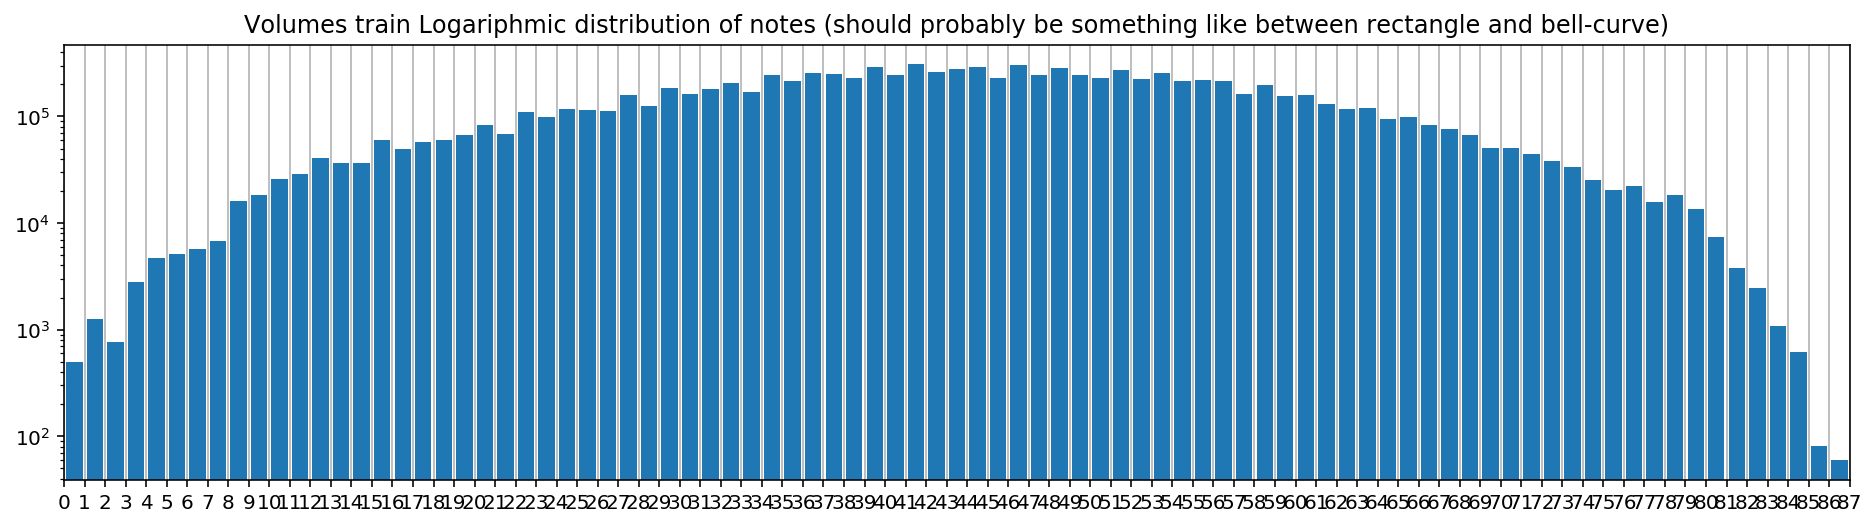

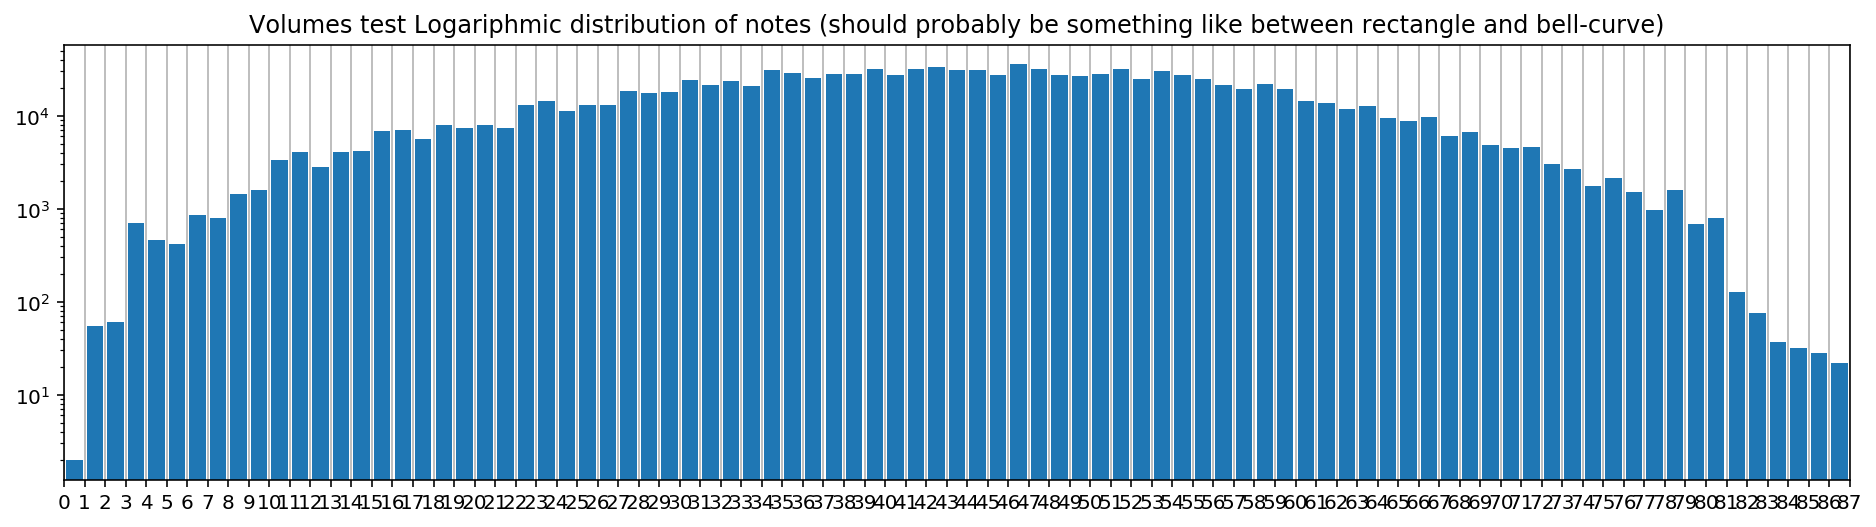

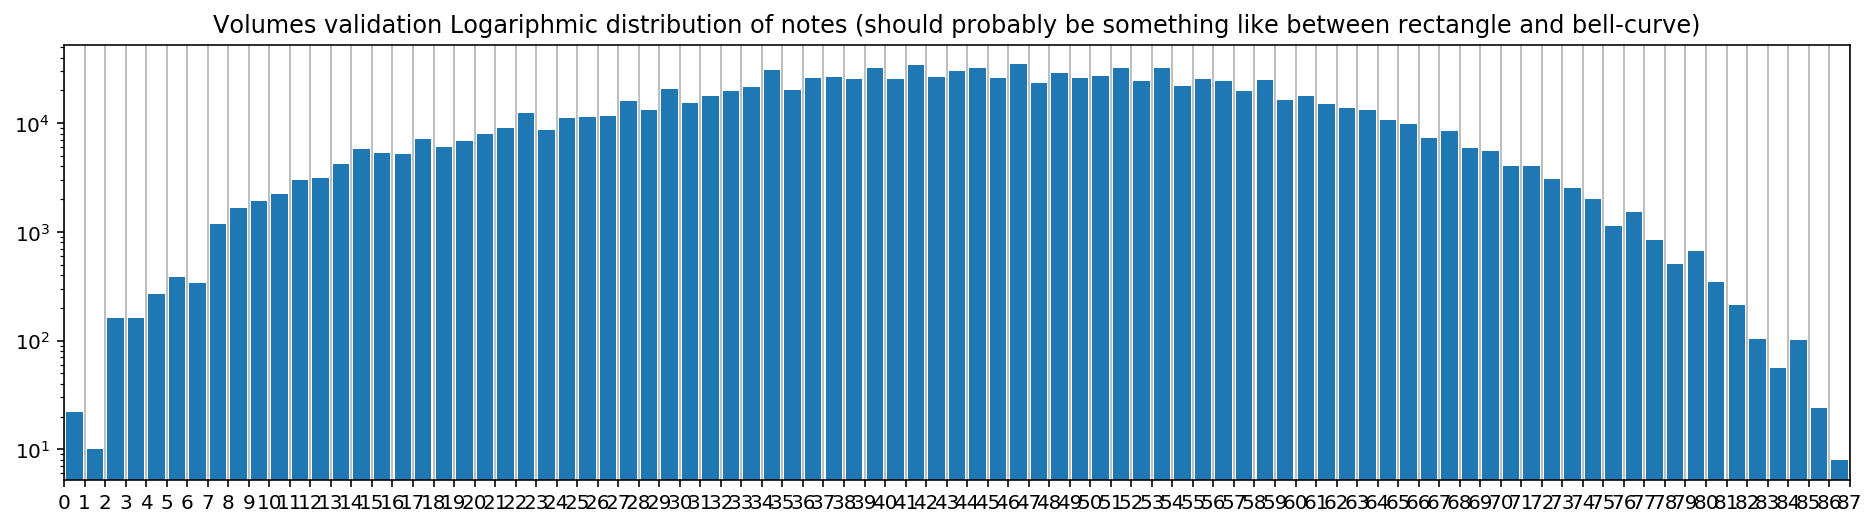

In [8]:
PlotNotes('Volumes') # Should be the same as Onsets and Offsets

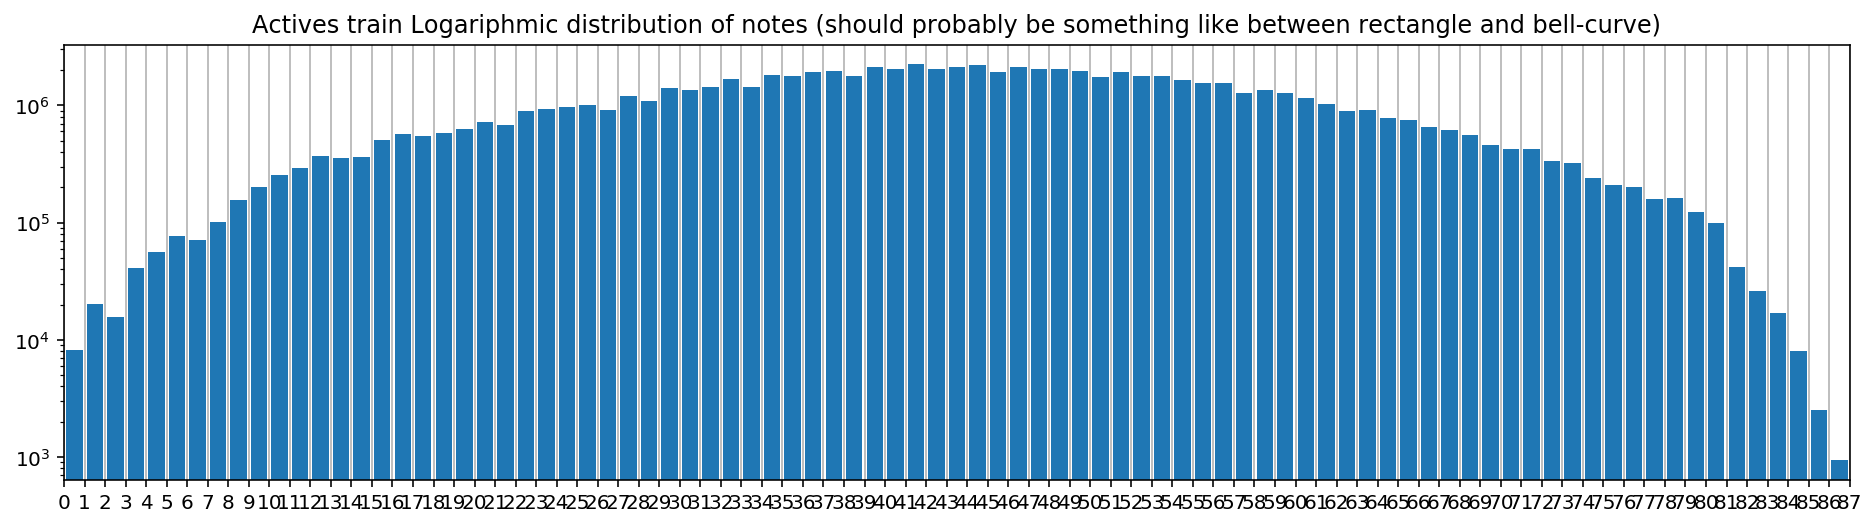

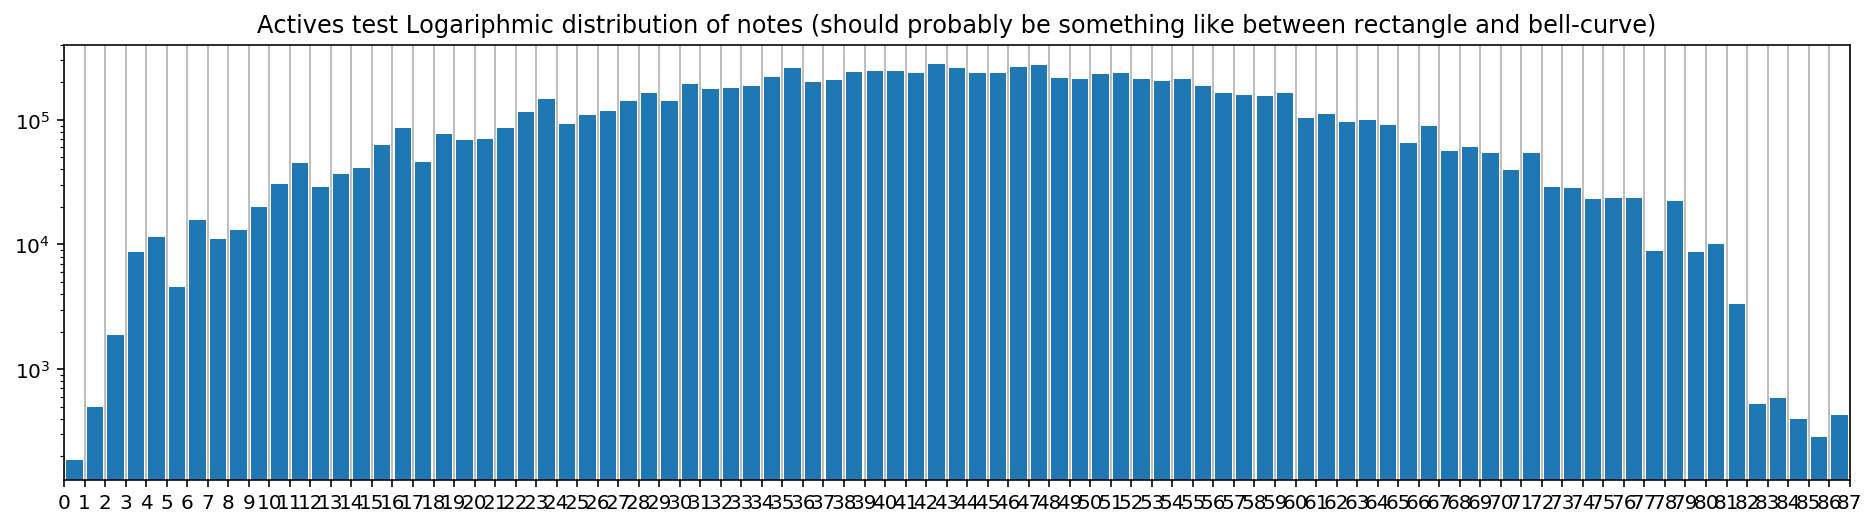

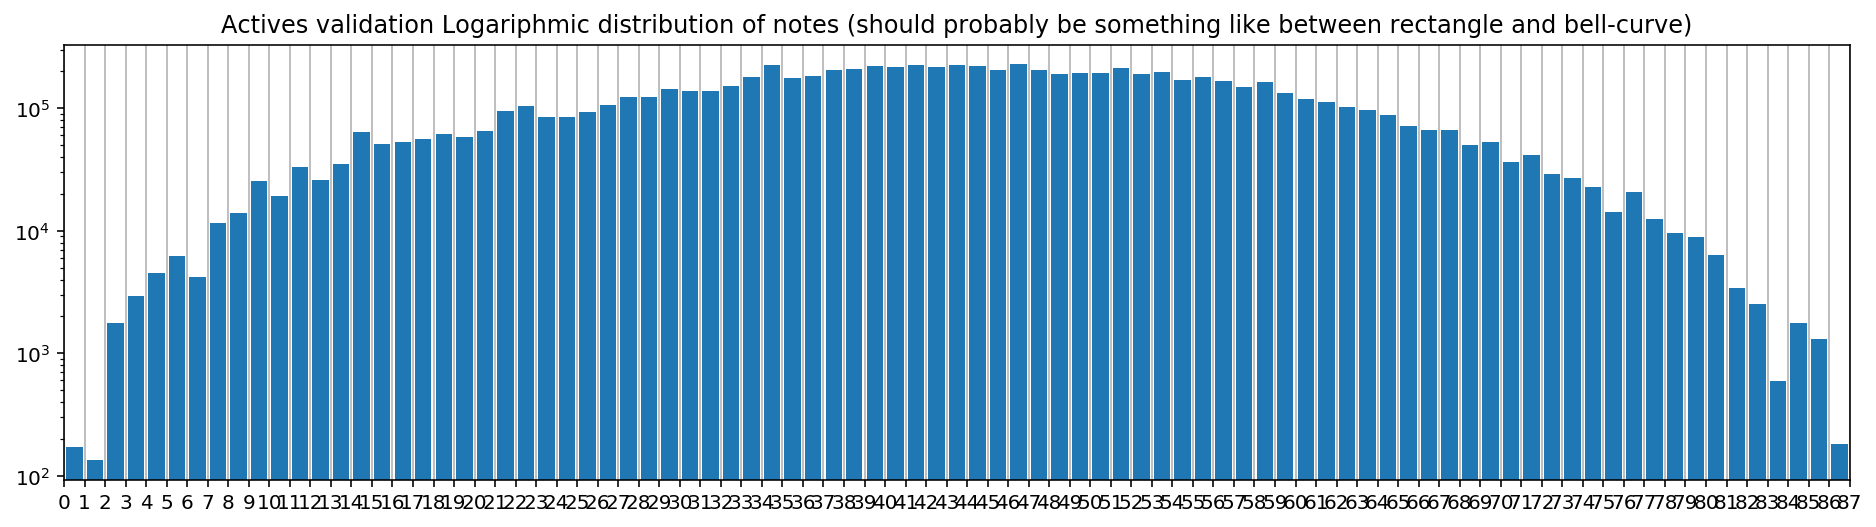

In [9]:
PlotNotes('Actives')